# October ??th, 2021

**Motivation**: Bootstrap results <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from scipy.ndimage import gaussian_filter

def show_h(proj_h, proj_hr, cmap='icefire', interp='antialiased', display: bool = True):
    fig, axes = create_figure(1, 4, (13., 3), gridspec_kw={'width_ratios': [1.8, 1, 1, 1.8]})

    x2plt = proj_h['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    if display:
        plt.show()
    else:
        plt.close()
    return fig, axes
    
    
def get_h(pi_arr, approach='pi_animals'):
    if approach == 'pi_animals':
        pi = bn.nanmean(pi_arr, -3)
        pi = bn.nanmean(bn.nanmean(pi, 2), 1)
        h = sp_stats.entropy(pi, axis=-2) / np.log(pi.shape[-2])
        h = bn.nanmean(h, 0)
        hr = sp_stats.rankdata(h)
    elif approach == 'avg_pi_first':
        pi = bn.nanmean(pi_arr, -3)
        pi = bn.nanmean(bn.nanmean(bn.nanmean(pi, 2), 1), 0)
        h = sp_stats.entropy(pi, axis=0) / np.log(len(pi))
        hr = sp_stats.rankdata(h)
    elif approach == 'no_pi_avg':
        h_arr = sp_stats.entropy(pi_arr, axis=-2) / np.log(pi_arr.shape[-2])
        h = bn.nanmean(h_arr, -3)
        h = bn.nanmean(bn.nanmean(bn.nanmean(h, 2), 1), 0)
    hr = sp_stats.rankdata(h)
    proj_h = gr.project_vec(h)
    proj_hr = gr.project_vec(hr)
    return h, hr, proj_h, proj_hr

In [3]:
%%time

mice = Mice((192, 4))

CPU times: user 376 ms, sys: 1.68 s, total: 2.06 s
Wall time: 2.56 s


In [4]:
mice.setup_func_data()

## k6 / p10-sample

In [5]:
props = {
    'mice': mice,
    'num_k': 6,
    'perc': 'p10-sample',
    'metric': 'pearson',
    'match_metric': 'euclidean',
    'match_using': 'gam',
    'prepare_data': False,
    'verbose': False,
}

### Bold & Ca2

In [6]:
# ca2
gr = Group(mode='ca2', centroids_from='runs', **props)
pi_arr_ca, _, _ = gr.fit_group(skip_align=False)

pi = bn.nanmean(pi_arr_ca, -3)
pi_ca = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)
disjoint = gr.get_disjoint_community(pi_ca, to_vec=True)
pi_ca = np.concatenate([pi_ca, np.expand_dims(disjoint, 0)])

# bold
gr = Group(mode='bold-lite', centroids_from='runs', **props)
pi_arr_bold, _, _ = gr.fit_group(skip_align=False)

pi = bn.nanmean(pi_arr_bold, -3)
pi_bold = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)
disjoint = gr.get_disjoint_community(pi_bold, to_vec=True)
pi_bold = np.concatenate([pi_bold, np.expand_dims(disjoint, 0)])

Warning, nan in global order

Warning, nan in global order

In [7]:
proj_ca = gr.project_vec(pi_ca)
proj_bold = gr.project_vec(pi_bold)

In [14]:
fig, axes = gr.show(
    proj_1=proj_bold, proj_2=proj_ca,
    labels=('BOLD-Lite', 'CA2'),
    cmaps=('rocket', 'mako'),
    interpolation='none',
    display=False,
)
sup = fig.suptitle('k6 / p10-sample', fontsize=20, y=1.03)

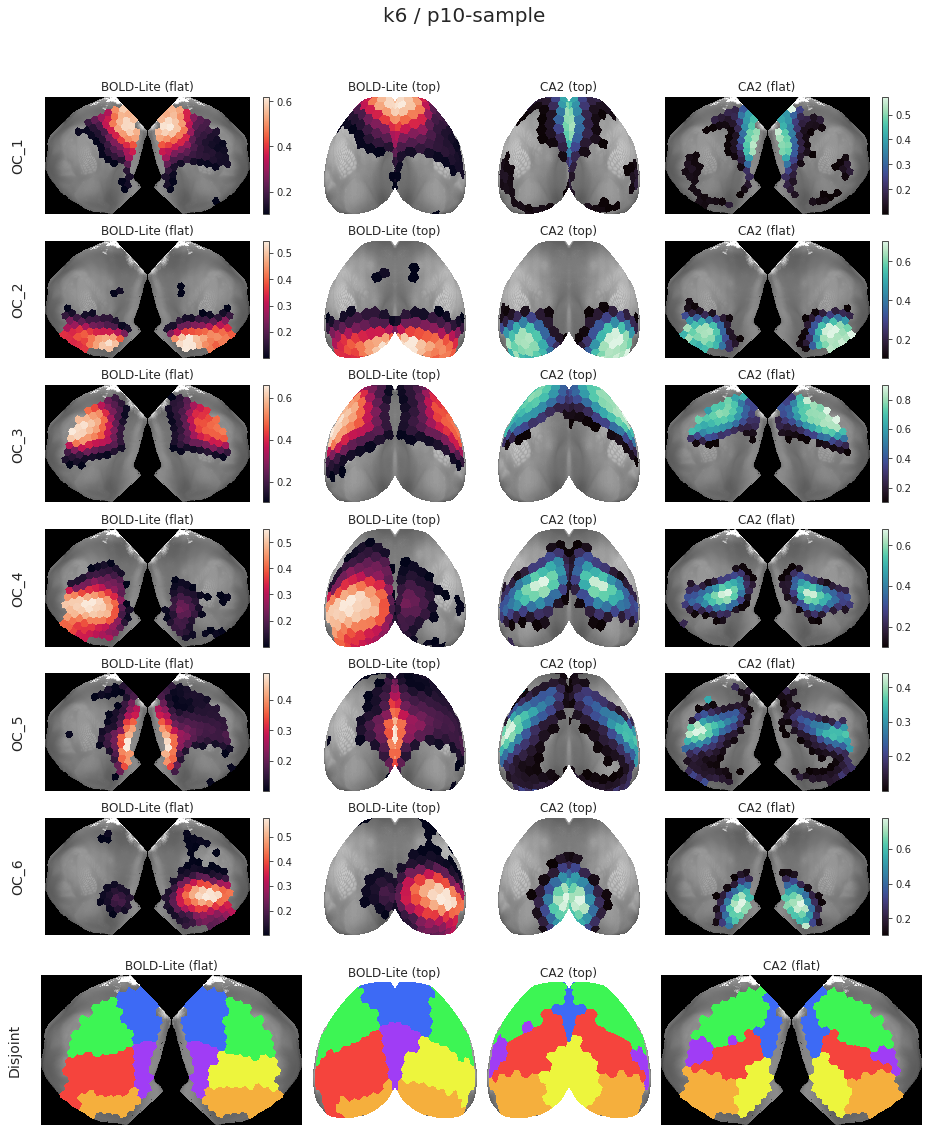

In [15]:
fig

In [16]:
sv = SVINET(**props, mode='bold-lite')
print(f"BOLD sym :\t{sv.pi_symmetry_score(pi_bold, 3)}")

sv = SVINET(**props, mode='ca2')
print(f"CA2 sym :\t{sv.pi_symmetry_score(pi_ca, 3)}")

BOLD sym :      {1: 0.988, 2: 0.997, 3: 0.994, 4: 0.89, 5: 0.981, 6: 0.855, -1: 0.951}

CA2 sym :       {1: 0.972, 2: 0.984, 3: 0.986, 4: 0.989, 5: 0.958, 6: 0.987, -1: 0.979}

In [24]:
h_ca, hr, proj_h, proj_hr = get_h(pi_arr_ca, 'pi_animals')
fig_h_ca, _ = show_h(proj_h, proj_hr, display=False)

h_bold, hr, proj_h, proj_hr = get_h(pi_arr_bold, 'pi_animals')
fig_h_bold, _ = show_h(proj_h, proj_hr, display=False)

In [27]:
sup_h_ca = fig_h_ca.suptitle("CA2 entropies", fontsize=15, y=1.01)
sup_h_bold = fig_h_bold.suptitle("BOLD entropies", fontsize=15, y=1.01)

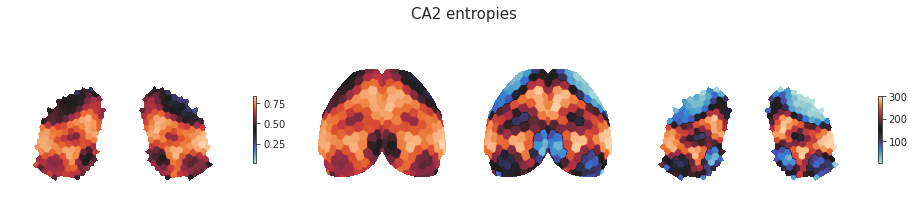

In [28]:
fig_h_ca

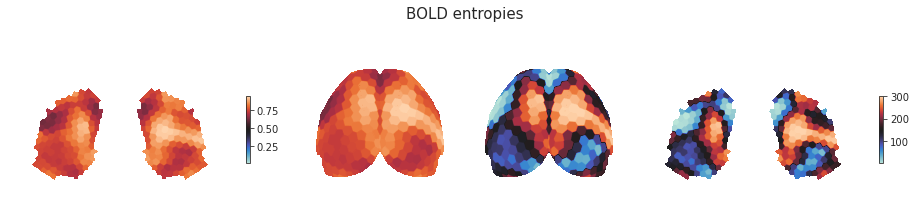

In [29]:
fig_h_bold

## BOOTSTRAP